In [1]:
%matplotlib inline
import torch
import random
from d2l import torch as d2l

## 根据带有噪声的线性模型构造一个人造数据集。我们使用线性模型参数$w=[2,-3.4]^T$、$b=4.2$和噪声项$\epsilon$生成数据集及标签：
$$
y = Xw+b+\epsilon
$$

In [41]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声"""
    X = torch.normal(mean=0, std=1, size=(num_examples, len(w)))  # 两个特征
    y = X @ w + b  # (num_examples, 2) x (2, 1)
    y += torch.normal(mean=0, std=0.01, size=y.shape)  # 添加均值为0，标准差为0.01的噪声
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)  # 生成1000个样本

## features中的每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值（一个标量）

In [42]:
print(f"第0个样本:{features[0]}\n第0个样本的特征:{labels[0]}")

第0个样本:tensor([-2.2394, -1.0969])
第0个样本的特征:tensor([3.4436])


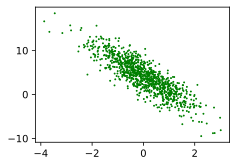

In [43]:
d2l.set_figsize((3.5, 2.5))
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), s=1, c="green")  # s=1表示圆圈的直径

## 定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [44]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 随机打乱indices列表
    for i in range(0, num_examples, batch_size):  # [0, batch_size, 2*batch_size, 3*batch_size, ...)
        # list[i:i + batch_size] 表示从list的第i位置开始取，取batch_size个
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.1374,  1.0791],
        [ 1.2167,  0.3164],
        [-0.9589,  0.9922],
        [ 0.4619,  0.1102],
        [-0.3646, -0.4295],
        [ 0.0733,  0.0964],
        [ 0.3736,  0.8166],
        [-0.5248,  1.3004],
        [-0.9680,  0.0208],
        [-1.0733,  0.5741]]) 
 tensor([[ 0.8206],
        [ 5.5681],
        [-1.0669],
        [ 4.7464],
        [ 4.9485],
        [ 4.0321],
        [ 2.1715],
        [-1.2847],
        [ 2.1890],
        [ 0.1026]])


## 初始化模型参数

In [45]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型

In [46]:
def linreg(X, w, b):
    """线性回归模型"""
    return X @ w + b

## 定义损失函数

In [47]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2  # 此处的损失函数没有求均值

## 定义优化算法

In [48]:
def sgd(params:list, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size  # 因为上面损失函数计算时没有求均值，所以此处/batch_size
            param.grad.zero_()  # 更新完参数后，将参数的梯度归零

## 训练过程

In [49]:
lr = 0.03
num_epochs = 3
net = linreg  # 给函数换个名字
loss = squared_loss  # 给函数换个名字

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        # l的形状是(batch_size, 1)，而不是标量
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        # 一个epoch训练结束后，把整个数据传进去，计算损失
        train_l = loss(net(features, w, b), labels)
        print(f"epoch {epoch + 1}, loss {train_l.mean().item():.4f}")

epoch 1, loss 0.0357
epoch 2, loss 0.0001
epoch 3, loss 0.0001


In [54]:
print(f"w的估计误差：{true_w - w.detach().reshape(true_w.shape)}")
print(f"b的估计误差：{(true_b - b.detach().item()):.5f}")

w的估计误差：tensor([ 0.0005, -0.0001])
b的估计误差：0.00020
